In [1]:
import csv
import math
import random
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.ensemble import BaggingRegressor
import pickle
from copy import deepcopy

In [2]:
def process_df(df):
  new_df = deepcopy(df)
  new_df["period_index"] = pd.PeriodIndex(df.sale_date, freq="Q")
  new_df.drop(columns=["id", "sale_date", "address", "latitude_rad", "longitude_rad", "latitude", "longitude", "psm"], inplace=True)
  new_df = pd.get_dummies(new_df, columns=["flat_type", "flat_model", "town"], dummy_na = True, dtype=np.uint8)
  new_df.drop(columns=["town_nan", "flat_type_nan", "flat_model_nan"], inplace=True)
  return new_df

In [3]:
def train_test_split(df, period):
  train = df[df["period_index"] != period]
  test = df[df["period_index"] == period]
  
  X_train, y_train = train[train.columns.difference(["cpi_psm", "period_index"])], train["cpi_psm"]
  X_test, y_test = test[test.columns.difference(["cpi_psm", "period_index"])], test["cpi_psm"]
  return X_train, X_test, y_train, y_test

In [4]:
PROCESSED_DATA_PATH = os.path.join("../", "../", "data_processed", "resale_flat_prices")
SEED = 42

In [5]:
df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, "engineered_data.csv"))
df.head(10)

,id,town,flat_type,flat_model,sale_date,floor,age,relative_tenure,floor_area,psm,...,nearest_post_offices,nearest_bus_stops,nearest_pharmacies,nearest_primary_schools,nearest_parks,nearest_trains,sale_month,cpi,cpi_psm,avg_sora
0,1,JURONG_WEST,3_ROOM,IMPROVED,1990-01-01,5.0,16,0.899953,70.0,334.285714,...,0.798752,0.195397,0.761661,0.541789,0.947906,0.904104,1,61.9,595.125779,NaN
1,2,OTHER,5_ROOM,STANDARD,1990-01-01,5.0,15,0.902280,120.0,916.666667,...,3.042559,0.090376,1.133326,0.159056,0.330270,1.954674,1,61.9,1631.933226,NaN
2,3,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,5.0,15,0.902280,63.0,722.222222,...,1.148847,0.446105,0.850333,0.943485,0.737703,0.932695,1,61.9,1285.765572,NaN
3,4,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,8.0,21,0.887322,29.0,251.724138,...,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1,61.9,448.142165,NaN
4,5,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,11.0,21,0.887322,29.0,251.724138,...,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1,61.9,448.142165,NaN
5,6,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,8.0,21,0.887322,29.0,310.344828,...,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1,61.9,552.504039,NaN
6,7,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,8.0,7,0.918820,64.0,687.500000,...,1.018641,0.485058,0.986821,0.800866,0.808590,0.940111,1,61.9,1223.949919,NaN
7,8,BUKIT_MERAH,3_ROOM,MODEL_A,1990-01-01,8.0,6,0.920652,74.0,1128.378378,...,1.089870,0.544915,0.567711,0.490547,0.708861,0.799126,1,61.9,2008.841636,NaN
8,9,BUKIT_MERAH,3_ROOM,MODEL_A,1990-01-01,5.0,6,0.920652,73.0,1150.684932,...,1.657478,0.053197,0.982875,0.340834,1.013329,0.940071,1,61.9,2048.553788,NaN
9,10,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,2.0,15,0.902280,76.0,671.052632,...,0.690789,0.083148,0.637859,0.507003,0.406147,1.175060,1,61.9,1194.668821,NaN


In [6]:
df["is_imputted_sora"] = np.where(df["avg_sora"].isnull(), True, False)

imp = SimpleImputer()
df["avg_sora"] = imp.fit_transform(df["avg_sora"].to_numpy().reshape(-1, 1))

In [7]:
df.describe()

,id,floor,age,relative_tenure,floor_area,psm,latitude,longitude,latitude_rad,longitude_rad,...,nearest_post_offices,nearest_bus_stops,nearest_pharmacies,nearest_primary_schools,nearest_parks,nearest_trains,sale_month,cpi,cpi_psm,avg_sora
count,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,...,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000
mean,432914.000000,7.626058,17.349350,0.892896,96.135123,3173.083607,1.497366,103.148474,0.026134,1.800280,...,62.788172,61.708270,62.231490,61.990540,62.338973,62.217020,190.483063,82.131055,4131.625468,0.763427
std,249942.870098,4.738340,10.217708,0.029046,25.796313,1385.776553,2.612377,11.573640,0.045595,0.201998,...,923.588875,923.284911,923.497181,923.502716,923.385468,923.496916,104.298678,11.879488,1363.166128,0.659903
min,1.000000,2.000000,0.000000,0.731586,28.000000,161.290323,-37.840251,-122.683299,-0.660437,-2.141228,...,0.007724,0.000003,0.000790,0.042886,0.021691,0.018401,1.000000,61.900000,284.387097,0.035633
25%,216457.500000,5.000000,9.000000,0.878870,73.000000,2266.666667,1.335322,103.772049,0.023306,1.811164,...,0.754831,0.076599,0.395358,0.241143,0.477918,0.375599,107.000000,73.400000,3321.083800,0.260618
50%,432914.000000,8.000000,16.000000,0.899953,93.000000,2870.370370,1.355961,103.843296,0.023666,1.812407,...,1.136412,0.112533,0.610644,0.370503,0.705703,0.585058,175.000000,76.500000,4031.953168,0.763427
75%,649370.500000,11.000000,24.000000,0.915007,114.000000,3990.180006,1.383056,103.897860,0.024139,1.813360,...,1.559133,0.156376,0.869802,0.540301,0.994037,0.853369,269.000000,95.900000,4868.754343,0.763427
max,865827.000000,50.000000,55.000000,0.930702,307.000000,13310.344828,50.820779,145.019498,0.886990,2.531068,...,16929.865540,16924.138572,16928.066230,16927.190593,16926.344996,16927.966733,393.000000,110.200000,14163.126574,3.414986


In [8]:
new_df = process_df(df)
sample_values = new_df.sample(frac=0.1, random_state=SEED)
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(sample_values, pd.Period(value="2022Q3"))

In [9]:
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=SEED), random_state=SEED)

# GridSearchCV

In [10]:
parameters = {'n_estimators':[10,50,100,200], 'max_samples':[0.1,0.2,0.5,0.7,1.0], 'max_features':[0.1,0.2,0.5,0.7,1.0]}
grid = GridSearchCV(model, parameters, scoring='neg_root_mean_squared_error', verbose = 4, return_train_score = True)
grid.fit(X=X_train_sample, y=y_train_sample)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END max_features=0.1, max_samples=0.1, n_estimators=10;, score=(train=-1097.951, test=-1127.169) total time=   0.2s
[CV 2/5] END max_features=0.1, max_samples=0.1, n_estimators=10;, score=(train=-1097.256, test=-1143.990) total time=   0.3s
[CV 3/5] END max_features=0.1, max_samples=0.1, n_estimators=10;, score=(train=-1092.416, test=-1144.780) total time=   0.2s
[CV 4/5] END max_features=0.1, max_samples=0.1, n_estimators=10;, score=(train=-1091.093, test=-1144.222) total time=   0.2s
[CV 5/5] END max_features=0.1, max_samples=0.1, n_estimators=10;, score=(train=-1092.202, test=-1120.608) total time=   0.2s
[CV 1/5] END max_features=0.1, max_samples=0.1, n_estimators=50;, score=(train=-901.348, test=-935.343) total time=   1.6s
[CV 2/5] END max_features=0.1, max_samples=0.1, n_estimators=50;, score=(train=-902.925, test=-954.238) total time=   1.5s
[CV 3/5] END max_features=0.1, max_samples=0.1, n_estimators=50;, 

[CV 2/5] END max_features=0.1, max_samples=0.7, n_estimators=50;, score=(train=-726.873, test=-855.349) total time=   5.8s
[CV 3/5] END max_features=0.1, max_samples=0.7, n_estimators=50;, score=(train=-725.920, test=-857.453) total time=   5.0s
[CV 4/5] END max_features=0.1, max_samples=0.7, n_estimators=50;, score=(train=-726.950, test=-854.830) total time=   5.0s
[CV 5/5] END max_features=0.1, max_samples=0.7, n_estimators=50;, score=(train=-727.835, test=-845.793) total time=   4.9s
[CV 1/5] END max_features=0.1, max_samples=0.7, n_estimators=100;, score=(train=-796.424, test=-886.531) total time=  10.6s
[CV 2/5] END max_features=0.1, max_samples=0.7, n_estimators=100;, score=(train=-795.619, test=-899.132) total time=   8.9s
[CV 3/5] END max_features=0.1, max_samples=0.7, n_estimators=100;, score=(train=-794.796, test=-900.838) total time=   8.3s
[CV 4/5] END max_features=0.1, max_samples=0.7, n_estimators=100;, score=(train=-795.650, test=-900.169) total time=   8.2s
[CV 5/5] END

[CV 4/5] END max_features=0.2, max_samples=0.2, n_estimators=100;, score=(train=-610.861, test=-706.805) total time=   6.6s
[CV 5/5] END max_features=0.2, max_samples=0.2, n_estimators=100;, score=(train=-611.696, test=-693.645) total time=   6.6s
[CV 1/5] END max_features=0.2, max_samples=0.2, n_estimators=200;, score=(train=-595.950, test=-680.466) total time=  13.6s
[CV 2/5] END max_features=0.2, max_samples=0.2, n_estimators=200;, score=(train=-594.834, test=-689.757) total time=  13.7s
[CV 3/5] END max_features=0.2, max_samples=0.2, n_estimators=200;, score=(train=-594.524, test=-695.398) total time=  13.7s
[CV 4/5] END max_features=0.2, max_samples=0.2, n_estimators=200;, score=(train=-595.359, test=-693.697) total time=  13.7s
[CV 5/5] END max_features=0.2, max_samples=0.2, n_estimators=200;, score=(train=-596.492, test=-681.381) total time=  13.7s
[CV 1/5] END max_features=0.2, max_samples=0.5, n_estimators=10;, score=(train=-506.162, test=-675.067) total time=   1.3s
[CV 2/5] 

[CV 1/5] END max_features=0.5, max_samples=0.1, n_estimators=10;, score=(train=-460.001, test=-491.427) total time=   0.9s
[CV 2/5] END max_features=0.5, max_samples=0.1, n_estimators=10;, score=(train=-464.823, test=-507.201) total time=   1.0s
[CV 3/5] END max_features=0.5, max_samples=0.1, n_estimators=10;, score=(train=-462.487, test=-510.075) total time=   0.9s
[CV 4/5] END max_features=0.5, max_samples=0.1, n_estimators=10;, score=(train=-461.164, test=-504.365) total time=   1.0s
[CV 5/5] END max_features=0.5, max_samples=0.1, n_estimators=10;, score=(train=-463.463, test=-497.487) total time=   0.9s
[CV 1/5] END max_features=0.5, max_samples=0.1, n_estimators=50;, score=(train=-422.359, test=-454.320) total time=   5.0s
[CV 2/5] END max_features=0.5, max_samples=0.1, n_estimators=50;, score=(train=-421.265, test=-466.356) total time=   4.9s
[CV 3/5] END max_features=0.5, max_samples=0.1, n_estimators=50;, score=(train=-420.219, test=-469.594) total time=   4.9s
[CV 4/5] END max

[CV 3/5] END max_features=0.5, max_samples=0.7, n_estimators=50;, score=(train=-195.449, test=-379.261) total time=  24.2s
[CV 4/5] END max_features=0.5, max_samples=0.7, n_estimators=50;, score=(train=-195.367, test=-377.157) total time=  24.4s
[CV 5/5] END max_features=0.5, max_samples=0.7, n_estimators=50;, score=(train=-195.507, test=-371.034) total time=  24.4s
[CV 1/5] END max_features=0.5, max_samples=0.7, n_estimators=100;, score=(train=-195.366, test=-369.729) total time=  47.4s
[CV 2/5] END max_features=0.5, max_samples=0.7, n_estimators=100;, score=(train=-194.702, test=-375.436) total time=  47.5s
[CV 3/5] END max_features=0.5, max_samples=0.7, n_estimators=100;, score=(train=-194.521, test=-381.723) total time=  47.4s
[CV 4/5] END max_features=0.5, max_samples=0.7, n_estimators=100;, score=(train=-194.811, test=-378.487) total time=  47.4s
[CV 5/5] END max_features=0.5, max_samples=0.7, n_estimators=100;, score=(train=-194.869, test=-372.361) total time=  47.7s
[CV 1/5] EN

[CV 5/5] END max_features=0.7, max_samples=0.2, n_estimators=100;, score=(train=-317.348, test=-382.845) total time=  23.6s
[CV 1/5] END max_features=0.7, max_samples=0.2, n_estimators=200;, score=(train=-312.184, test=-373.514) total time=  46.3s
[CV 2/5] END max_features=0.7, max_samples=0.2, n_estimators=200;, score=(train=-311.894, test=-381.560) total time=  44.0s
[CV 3/5] END max_features=0.7, max_samples=0.2, n_estimators=200;, score=(train=-311.266, test=-386.198) total time=  41.3s
[CV 4/5] END max_features=0.7, max_samples=0.2, n_estimators=200;, score=(train=-311.732, test=-382.962) total time=  42.1s
[CV 5/5] END max_features=0.7, max_samples=0.2, n_estimators=200;, score=(train=-312.554, test=-377.293) total time=  42.2s
[CV 1/5] END max_features=0.7, max_samples=0.5, n_estimators=10;, score=(train=-254.616, test=-378.144) total time=   4.3s
[CV 2/5] END max_features=0.7, max_samples=0.5, n_estimators=10;, score=(train=-251.951, test=-386.271) total time=   4.3s
[CV 3/5] E

[CV 2/5] END max_features=1.0, max_samples=0.1, n_estimators=10;, score=(train=-400.500, test=-434.634) total time=   2.1s
[CV 3/5] END max_features=1.0, max_samples=0.1, n_estimators=10;, score=(train=-402.581, test=-446.043) total time=   2.0s
[CV 4/5] END max_features=1.0, max_samples=0.1, n_estimators=10;, score=(train=-400.295, test=-437.154) total time=   2.1s
[CV 5/5] END max_features=1.0, max_samples=0.1, n_estimators=10;, score=(train=-402.602, test=-434.603) total time=   2.1s
[CV 1/5] END max_features=1.0, max_samples=0.1, n_estimators=50;, score=(train=-375.192, test=-407.088) total time=  10.7s
[CV 2/5] END max_features=1.0, max_samples=0.1, n_estimators=50;, score=(train=-370.799, test=-410.199) total time=  10.5s
[CV 3/5] END max_features=1.0, max_samples=0.1, n_estimators=50;, score=(train=-371.974, test=-416.013) total time=  10.7s
[CV 4/5] END max_features=1.0, max_samples=0.1, n_estimators=50;, score=(train=-371.209, test=-409.542) total time=  10.6s
[CV 5/5] END max

[CV 4/5] END max_features=1.0, max_samples=0.7, n_estimators=50;, score=(train=-171.012, test=-336.318) total time=  50.1s
[CV 5/5] END max_features=1.0, max_samples=0.7, n_estimators=50;, score=(train=-171.478, test=-333.787) total time=  54.7s
[CV 1/5] END max_features=1.0, max_samples=0.7, n_estimators=100;, score=(train=-168.542, test=-329.277) total time= 1.8min
[CV 2/5] END max_features=1.0, max_samples=0.7, n_estimators=100;, score=(train=-167.784, test=-332.136) total time= 1.6min
[CV 3/5] END max_features=1.0, max_samples=0.7, n_estimators=100;, score=(train=-166.416, test=-336.676) total time= 1.6min
[CV 4/5] END max_features=1.0, max_samples=0.7, n_estimators=100;, score=(train=-167.387, test=-334.240) total time= 1.4min
[CV 5/5] END max_features=1.0, max_samples=0.7, n_estimators=100;, score=(train=-168.164, test=-329.830) total time= 1.4min
[CV 1/5] END max_features=1.0, max_samples=0.7, n_estimators=200;, score=(train=-166.877, test=-328.292) total time= 2.9min
[CV 2/5] E

GridSearchCV(estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=42),
                                        random_state=42),
             param_grid={'max_features': [0.1, 0.2, 0.5, 0.7, 1.0],
                         'max_samples': [0.1, 0.2, 0.5, 0.7, 1.0],
                         'n_estimators': [10, 50, 100, 200]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=4)

In [11]:
print("Best Score: %f" % grid.best_score_) 
print("Best params: ", grid.best_params_)

Best Score: -327.812505
Best params:  {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}


In [12]:
pickle.dump(grid, open("grid_dt_v2_bagging.sav", "wb"))

In [13]:
model = grid.best_estimator_

X_train, X_test, y_train, y_test = train_test_split(new_df, pd.Period(value = "2022Q3"))

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
model.score(X_test, y_test)

0.8602403042584055

In [14]:
pickle.dump(model, open("model_dt_v2_bagging.pkl", "wb"))

# Metrics

In [15]:
def produce_metrics(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  rtwo = r2_score(y_test, y_pred)
  mape = mean_absolute_percentage_error(y_test, y_pred)
  mdape = median_absolute_error(y_test, y_pred)/np.median(y_test)
  return mse, mse**(0.5), mae, rtwo, mape, mdape

In [16]:
mse, rmse, mae, rtwo, mape, mdape = produce_metrics(y_test, y_pred)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {rtwo}")
print(f"MAPE: {mape}")
print(f"MdAPE: {mdape}")

MSE: 236952.7320198561
RMSE: 486.77790831122985
MAE: 351.9159392440663
R2: 0.8602403042584055
MAPE: 0.0621783386883835
MdAPE: 0.043453384671183565


# Feature Importance

In [18]:
feature_impts = {}

# Calculate feature importances manually with the means
feature_importances = np.mean([
    tree.feature_importances_ for tree in model.estimators_
], axis=0)

for feature, importance in zip(model.feature_names_in_, feature_importances):
    feature_impts[feature] = importance
feature_impts = dict(sorted(feature_impts.items(), key=lambda item: item[1], reverse=True)) # sort
print(feature_impts)

{'sale_month': 0.5704573158404149, 'nearest_bus_stops': 0.0652446534126951, 'floor_area': 0.05112012023920057, 'nearest_hawkers': 0.0347137883749086, 'age': 0.031236164912826766, 'relative_tenure': 0.025157520031785133, 'floor': 0.023666057838489345, 'cpi': 0.020954171527376237, 'nearest_trains': 0.01768769781678712, 'town_WOODLANDS': 0.01430122170890898, 'town_BISHAN': 0.011112653004026475, 'avg_sora': 0.011043929136518612, 'flat_type_4_ROOM': 0.01086248151479531, 'town_JURONG_WEST': 0.009412199993770002, 'nearest_post_offices': 0.007676874548588624, 'nearest_parks': 0.007515986396705592, 'town_OTHER': 0.007123343780931411, 'nearest_libraries': 0.006549229584976055, 'flat_model_OTHER': 0.006519125031678433, 'nearest_pharmacies': 0.006339377135309624, 'nearest_atm': 0.00569330431630792, 'town_BUKIT_PANJANG': 0.00535206797756393, 'town_YISHUN': 0.005272960522975294, 'nearest_stores': 0.0050917315058884305, 'nearest_primary_schools': 0.005061118477114174, 'town_BUKIT_MERAH': 0.0037630733

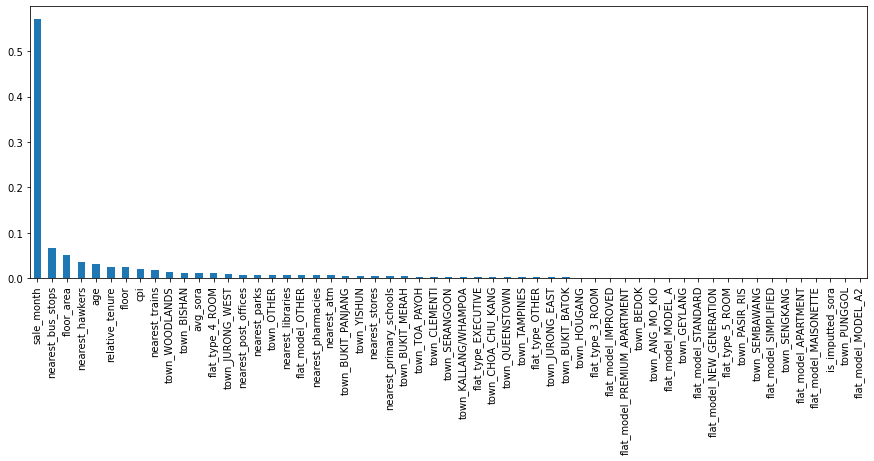

In [19]:
features_series = pd.Series(feature_impts.values(), index=feature_impts.keys())
features_series.sort_values(ascending=False,inplace=True)
plt.figure(figsize=(15,5))
features_series.plot(kind = 'bar')
plt.show()

# Actual vs Predicted

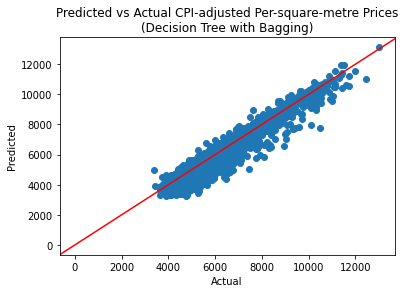

In [20]:
fig, ax = plt.subplots()
ax.axline((0, 0), slope=1, color="red")
plt.scatter(y_test, y_pred)
plt.title("Predicted vs Actual CPI-adjusted Per-square-metre Prices\n(Decision Tree with Bagging)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()